In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

from tensorflow import keras
from keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.utils import image_dataset_from_directory



2025-09-23 15:43:09.928645: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-23 15:43:10.733679: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-23 15:43:13.166691: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
from zipfile import ZipFile as zipfile 

data_path = r'/mnt/c/Users/User/Desktop/dogs-and-cats.zip'
with zipfile(data_path, 'r') as zips:
    zips.extractall()

In [3]:
# Set the path to your main image directory
base_dir = "PetImages" 
# You can change this to be the absolute path if needed, e.g., "/home/user/downloads/PetImages"

num_skipped = 0
# Walk through all the files and subdirectories
for folder_name in ("Cat", "Dog"): 
    folder_path = os.path.join(base_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            # Read the file content
            fobj = open(fpath, "rb")
            # Use tf.io.is_jpeg to check if it's a valid JPEG
            is_jpeg = tf.io.is_jpeg(fobj.read())
            fobj.close()
            
            # Additionally, try to decode it. This is the most robust check.
            # This is what fails during training.
            if is_jpeg:
                # Read file again for decoding
                raw_image = tf.io.read_file(fpath)
                # If it can't decode, it will raise an exception
                tf.io.decode_jpeg(raw_image)
            else:
                # If it's not even a valid JPEG format
                raise tf.errors.InvalidArgumentError(None, None, "Not a valid JPEG")

        except Exception as e:
            # If any exception occurs, the file is likely corrupt
            num_skipped += 1
            # To automatically delete the corrupt file, uncomment the line below
            # WARNING: This will permanently delete the files. Backup first!
            os.remove(fpath) 

print(f"Done! Found and skipped {num_skipped} corrupt images.")

I0000 00:00:1758618194.521265     935 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


Done! Found and skipped 229 corrupt images.


In [2]:
data = image_dataset_from_directory('PetImages')

Found 24769 files belonging to 2 classes.


I0000 00:00:1758631413.407843     802 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [ ]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
#image repr as numpy arrays
batch[0].shape

(32, 256, 256, 3)

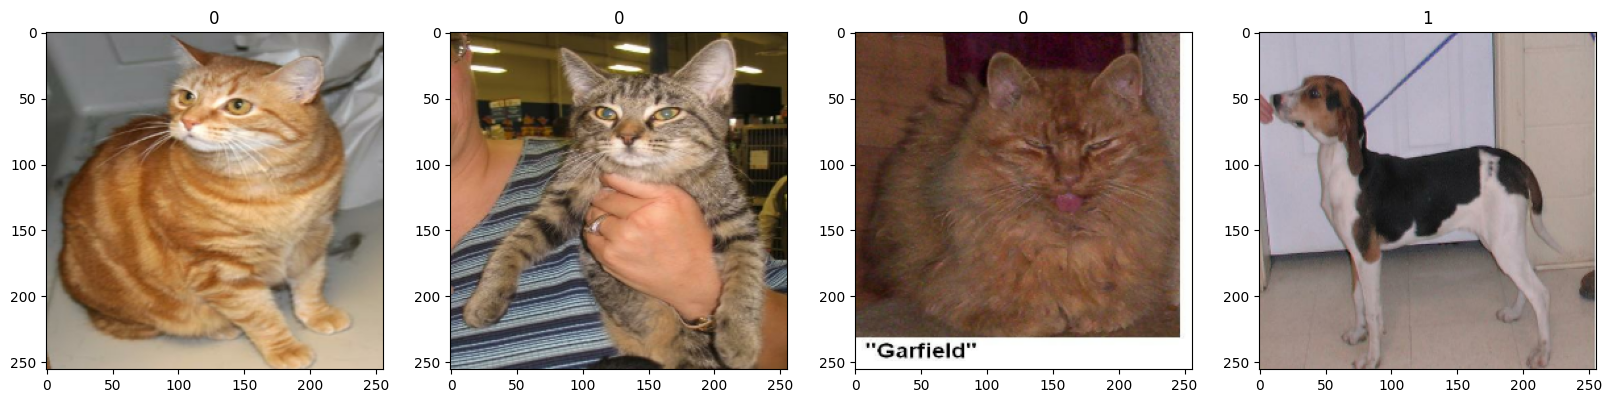

In [ ]:
#Cats - 0
#Dogs - 1
fig, ax = plt.subplots(ncols= 4, figsize = (20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [3]:
data = data.map(lambda x,y: (x/255, y))
scaled_iterator = data.as_numpy_iterator()


In [4]:
batch = scaled_iterator.next()

In [5]:
batch[0].max()

np.float32(1.0)

In [6]:
len(data)

775

In [7]:
train_size = int(len(data) * .7)
val_size = int(len(data) *.2) 
test_size = int(len(data)*.1) + 1

In [8]:
train_size + val_size + test_size

775

In [9]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [17]:
from tensorflow.keras.layers import MaxPooling2D

model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(512, activation = 'relu'))
model.add(layers.BatchNormalization())

model.add(Dense(256, activation = 'relu'))
model.add(layers.Dropout(0.1))
model.add(layers.BatchNormalization())


model.add(Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())

model.add(Dense(1, activation = 'sigmoid'))


/home/cook/deeplearning-linux/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.compile('adam', loss= tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [19]:
logdir = 'logs'
tensorflow_callback = tf.keras.callbacks.TensorBoard(log_dir= logdir)

In [20]:
hist = model.fit(train, epochs = 6, validation_data=val, callbacks = [tensorflow_callback])

Epoch 1/6


2025-09-23 16:11:23.092911: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-23 16:11:23.093061: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-23 16:11:23.093167: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-23 16:11:23.093190: I external/l

149/542 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.5521 - loss: 0.7634

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


234/542 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - accuracy: 0.5650 - loss: 0.7427

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


252/542 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - accuracy: 0.5677 - loss: 0.7389

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


259/542 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - accuracy: 0.5686 - loss: 0.7375

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


282/542 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.5717 - loss: 0.7331

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


291/542 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.5728 - loss: 0.7314

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


398/542 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.5857 - loss: 0.7135

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


423/542 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.5887 - loss: 0.7096

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


475/542 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.5946 - loss: 0.7019

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


503/542 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.5977 - loss: 0.6979

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


542/542 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6017 - loss: 0.6927

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
2025-09-23 16:12:09.874495: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 25166336 bytes after encountering the first element of size 25166336 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


542/542 ━━━━━━━━━━━━━━━━━━━━ 57s 74ms/step - accuracy: 0.6556 - loss: 0.6247 - val_accuracy: 0.6796 - val_loss: 0.6449
Epoch 2/6
142/542 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.7205 - loss: 0.5536

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


236/542 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 0.7239 - loss: 0.5466

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


243/542 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.7243 - loss: 0.5460

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


257/542 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.7249 - loss: 0.5450

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


267/542 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.7254 - loss: 0.5443

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


285/542 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.7262 - loss: 0.5430

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


396/542 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.7315 - loss: 0.5355

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


415/542 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.7323 - loss: 0.5344

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


456/542 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.7340 - loss: 0.5320

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/542 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.7356 - loss: 0.5295

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


542/542 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7370 - loss: 0.5276

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
2025-09-23 16:12:50.060548: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


542/542 ━━━━━━━━━━━━━━━━━━━━ 39s 72ms/step - accuracy: 0.7535 - loss: 0.5033 - val_accuracy: 0.7530 - val_loss: 0.5013
Epoch 3/6
160/542 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.7755 - loss: 0.4729

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


234/542 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.7785 - loss: 0.4694

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


267/542 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.7796 - loss: 0.4681

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


273/542 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.7797 - loss: 0.4679

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


279/542 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.7799 - loss: 0.4676

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


395/542 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.7841 - loss: 0.4617

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


418/542 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.7850 - loss: 0.4605

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


460/542 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.7865 - loss: 0.4584

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


506/542 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.7880 - loss: 0.4563

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


541/542 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7889 - loss: 0.4547

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
2025-09-23 16:13:29.012789: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


542/542 ━━━━━━━━━━━━━━━━━━━━ 39s 71ms/step - accuracy: 0.8035 - loss: 0.4314 - val_accuracy: 0.7637 - val_loss: 0.5129
Epoch 4/6
145/542 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.8114 - loss: 0.4061

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


249/542 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - accuracy: 0.8160 - loss: 0.4004

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


253/542 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - accuracy: 0.8161 - loss: 0.4002

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


269/542 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - accuracy: 0.8168 - loss: 0.3994

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


292/542 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.8178 - loss: 0.3981

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


403/542 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.8218 - loss: 0.3924

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


425/542 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.8225 - loss: 0.3913

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


468/542 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8238 - loss: 0.3891

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


523/542 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8254 - loss: 0.3864

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


542/542 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8259 - loss: 0.3856

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
2025-09-23 16:14:08.741489: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 25166336 bytes after encountering the first element of size 25166336 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


542/542 ━━━━━━━━━━━━━━━━━━━━ 40s 73ms/step - accuracy: 0.8387 - loss: 0.3631 - val_accuracy: 0.7806 - val_loss: 0.4996
Epoch 5/6
131/542 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - accuracy: 0.8459 - loss: 0.3418

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


222/542 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.8481 - loss: 0.3378

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


242/542 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - accuracy: 0.8488 - loss: 0.3365

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


265/542 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.8497 - loss: 0.3349

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


276/542 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.8501 - loss: 0.3341

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


399/542 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.8554 - loss: 0.3243

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


440/542 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.8569 - loss: 0.3214

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


464/542 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8578 - loss: 0.3198

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


487/542 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8586 - loss: 0.3183

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


542/542 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8602 - loss: 0.3152

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
2025-09-23 16:14:47.658164: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 41940736 bytes after encountering the first element of size 41940736 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


542/542 ━━━━━━━━━━━━━━━━━━━━ 39s 71ms/step - accuracy: 0.8749 - loss: 0.2873 - val_accuracy: 0.7492 - val_loss: 0.6364
Epoch 6/6
148/542 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - accuracy: 0.8921 - loss: 0.2625

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


222/542 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - accuracy: 0.8929 - loss: 0.2598

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


238/542 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.8933 - loss: 0.2589

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


244/542 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.8934 - loss: 0.2586

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


269/542 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.8941 - loss: 0.2573

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


386/542 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.8974 - loss: 0.2499

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


414/542 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.8981 - loss: 0.2484

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


458/542 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8991 - loss: 0.2463

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


505/542 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9001 - loss: 0.2442

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


542/542 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9007 - loss: 0.2428

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
2025-09-23 16:15:29.165177: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 25166336 bytes after encountering the first element of size 25166336 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


542/542 ━━━━━━━━━━━━━━━━━━━━ 42s 77ms/step - accuracy: 0.9085 - loss: 0.2260 - val_accuracy: 0.7690 - val_loss: 0.5584


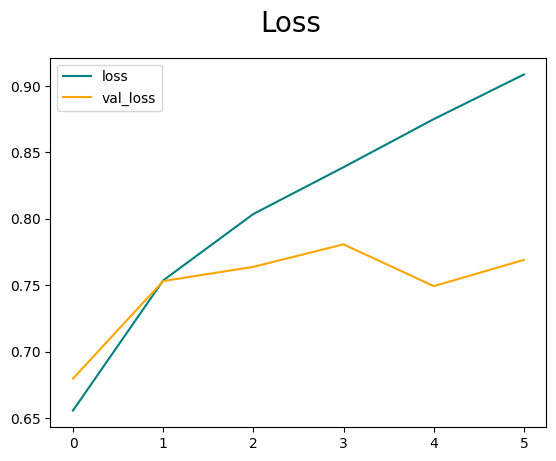

In [22]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color= 'teal', label = 'loss')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()


In [23]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy


In [24]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [25]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f'Precision:{[pre.result().numpy()]}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
2025-09-23 16:21:25.364121: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 41940224 bytes after encountering the first element of size 41940224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Precision:[np.float32(0.8039

2025-09-23 16:21:53.542541: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
